Imports

In [1]:
import numpy as np
import csv
from PIL import Image
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import math

In [2]:
w = 101
h = 101

Reading in Training Data

In [3]:
import pickle
data = pickle.load(open("training_separated.p", 'rb'))
X = data[0]
y = data[1]

In [4]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print("Training Shape")
print(X_train.shape)
print(y_train.shape)

print("Testing Shape")
print(X_test.shape)
print(y_train.shape)

In [5]:
class PictureHelper():
    
    def __init__(self):
        self.i = 0

        self.training_images = X_train
        self.training_labels = y_train
        
        self.testing_images = X_test
        self.testing_labels = y_test
    
    def getTesting(self, batch_size):
        # shuffle data
        p = np.random.permutation(len(self.testing_images))
        self.testing_images = self.testing_images[p]
        self.testing_labels = self.testing_labels[p]   
        if (batch_size < self.testing_images.shape[0]):
            x = self.testing_images[:batch_size]
            y = self.testing_labels[:batch_size]
        else:
            x = self.testing_images
            y = self.testing_labels
        
        return x, y
        
        
    def next_batch(self, batch_size):
        
        if (self.i + batch_size >= self.training_images.shape[0]):
            p = numpy.random.permutation(len(self.training_images))
            self.training_images = self.training_images[p]
            self.training_labels = self.training_labels[p]
            
        x = self.training_images[self.i:self.i+batch_size]
        y = self.training_labels[self.i:self.i+batch_size]
            
        self.i = (self.i + batch_size) % len(self.training_images)
        
        return x, y

In [6]:
ph = PictureHelper()
x, y = ph.getTesting(10)
print(x.shape)
print(y.shape)

(10, 101, 101, 1)
(10, 2)


## Creating the Model

** Import tensorflow **

In [7]:
import tensorflow as tf

In [8]:
x = tf.placeholder(tf.float32,shape=[None,w,h,1])
y_true = tf.placeholder(tf.float32,shape=[None,2])

In [9]:
hold_prob = tf.placeholder(tf.float32)

In [10]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

# Creating Layers

In [13]:
convo_1 = tf.nn.relu(convolutional_layer(x,shape=[2,2,1,32]))
convo_2 = tf.nn.relu(convolutional_layer(convo_1,shape=[2,2,32,16]))
convo_2_pooling = max_pool_2by2(convo_2)

convo_3 = tf.nn.relu(convolutional_layer(convo_2_pooling,shape=[2,2,16,64]))
convo_4 = tf.nn.relu(convolutional_layer(convo_3,shape=[2,2,64,32]))
convo_4_pooling = max_pool_2by2(convo_4)

convo_5 = tf.nn.relu(convolutional_layer(convo_4_pooling,shape=[2,2,32,128]))
convo_6 = tf.nn.relu(convolutional_layer(convo_5,shape=[2,2,128,128]))
convo_7 = tf.nn.relu(convolutional_layer(convo_6,shape=[2,2,128,64]))
convo_7_pooling = max_pool_2by2(convo_7)

convo_8 =  tf.nn.relu(convolutional_layer(convo_7_pooling, shape=[2,2,64,256]))
convo_9 =  tf.nn.relu(convolutional_layer(convo_8, shape=[2,2,256,256]))
convo_10 =  tf.nn.relu(convolutional_layer(convo_9, shape=[2,2,256,128]))
convo_10_pooling = max_pool_2by2(convo_10)

new_w = math.ceil(w / 16)
new_h = math.ceil(h / 16)

num_features = 128

convo_10_flat = tf.reshape(convo_10_pooling,[-1,new_h*new_w*num_features])

full_layer_1 = tf.nn.relu(normal_full_layer(convo_10_flat,1024))

full_layer_2 = tf.nn.relu(normal_full_layer(full_layer_1,1024))

full_dropout = tf.nn.dropout(full_layer_2,keep_prob=hold_prob)

y_pred = normal_full_layer(full_dropout,2)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



## Graph Session

** Perform the training and test print outs in a Tf session and run your model! **

In [14]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.90)

In [15]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4390793688158558777, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11280806708
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9186125818250589551
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [16]:
actual = []
predicted = []

In [ ]:
# config = tf.ConfigProto(gpu_options = gpu_options)
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(10000):
        ph = PictureHelper()
        batch = ph.next_batch(8)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 1.0})
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%10 == 0:
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Model
            x_test2, y_test2 = ph.getTesting(200)
            
            # metric for accuracy
            matches = tf.equal(tf.argmax(y_pred, axis = 1), tf.argmax(y_true, axis = 1))
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            
            # generating the predictions
            temp_acc = sess.run(acc,feed_dict={x:x_test2, y_true:y_test2, hold_prob:1.0})

            print(temp_acc)
            if (i%10==0):
                predicted.append(sess.run(y_pred, feed_dict = {x:x_test2, y_true:y_test2, hold_prob:1.0}))
                actual.append(y_test2)
                data = [actual, predicted]
                pickle.dump(data, open('results.p', 'wb'))

Currently on step 0
Accuracy is:
0.435
Currently on step 10
Accuracy is:
0.61
Currently on step 20
Accuracy is:
0.615
Currently on step 30
Accuracy is:
0.625
Currently on step 40
Accuracy is:
0.565
Currently on step 50
Accuracy is:
0.585
Currently on step 60
Accuracy is:
0.505
Currently on step 70
Accuracy is:
0.56
Currently on step 80
Accuracy is:
0.59
Currently on step 90
Accuracy is:
0.545
Currently on step 100
Accuracy is:
0.57
Currently on step 110
Accuracy is:
0.58
Currently on step 120
Accuracy is:
0.535
Currently on step 130
Accuracy is:
0.545
Currently on step 140
Accuracy is:
0.585
Currently on step 150
Accuracy is:
0.545
Currently on step 160
Accuracy is:
0.57
Currently on step 170
Accuracy is:
0.575
Currently on step 180
Accuracy is:
0.62
Currently on step 190
Accuracy is:
0.595
Currently on step 200
Accuracy is:
0.55
Currently on step 210
Accuracy is:
0.515
Currently on step 220
Accuracy is:
0.57
Currently on step 230
Accuracy is:
0.525
Currently on step 240
Accuracy is:
0

# Analyzing Results

In [32]:
data = pickle.load(open('results.p', 'rb'))
actual = np.array(data[0])
predicted = np.array(data[1])

In [33]:
predicted[predicted<0.5] = 0
predicted[predicted>=0.5] = 1

In [34]:
print(actual.shape)
print(predicted.shape)

(341, 200, 2)
(341, 200, 2)


In [35]:
actual = actual.transpose((2, 0, 1))
print(actual.shape)
predicted = predicted.transpose((2, 0, 1))
print(predicted.shape)

(2, 341, 200)
(2, 341, 200)


In [36]:
print(actual[0].shape)
print(actual.shape[2])
print(actual.shape[1])

(341, 200)
200
341


In [37]:
#actual = actual[0]
actual = actual[0].reshape(actual.shape[2], actual.shape[1])
predicted = predicted[0].reshape(predicted.shape[2], predicted.shape[1])
print(actual.shape)
print(predicted.shape)

(200, 341)
(200, 341)


In [38]:
accuracy = []
for i in range (actual.shape[0]):
    accuracy.append((len(actual[i][actual[i] == predicted[i]])) / actual.shape[1])

Text(0,0.5,'Accuracy')

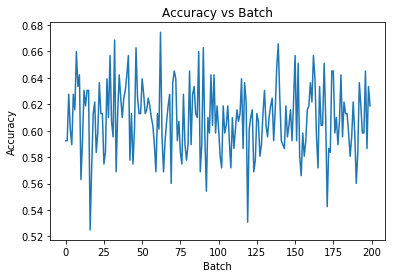

In [39]:
plt.plot(accuracy)
plt.title("Accuracy vs Batch")
plt.xlabel("Batch")
plt.ylabel("Accuracy")